In [333]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping


Developing a GPT sentiment analysis model with LSTM is necessary to improve the efficiency of sentiment analysis models in specific tasks or domains. LSTM could help capture long-term connections in text data, leading to better results in sentiment analysis. Also leveraging the strengths of both models, integrating GPT and LSTM leads to enhance the efficiency of sentiment analysis models.


## 1. Read data

In [273]:
!unzip sentiment.zip

Archive:  sentiment.zip
replace file.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: file.csv                


In [274]:
data = pd.read_csv('file.csv')
data.shape

(219294, 3)

## 2. EDA

In [275]:
data.isnull().sum()

Unnamed: 0    0
tweets        0
labels        0
dtype: int64

In [276]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  219294 non-null  int64 
 1   tweets      219294 non-null  object
 2   labels      219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [277]:
data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


<Axes: xlabel='labels'>

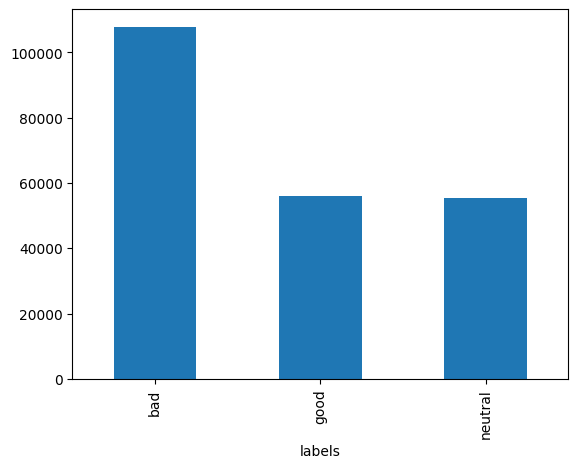

In [278]:
data["labels"].value_counts().plot(kind='bar')

## 3. Data Preprocess

### Data Split

In [294]:
#defining x and y
# x = data['tweets']
x=data.drop('labels',axis=1)
y = data['labels']

In [295]:
data = shuffle(data, random_state=42)  # Shuffle the dataset

# Calculate the number of rows
total_rows = len(data)

# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Calculate the indices for each split
train_end = int(total_rows * train_ratio)
val_end = train_end + int(total_rows * val_ratio)

# Split the dataset using iloc
train = data.iloc[:train_end]
val = data.iloc[train_end:val_end]
test = data.iloc[val_end:]

# Print the sizes of each set
print(f'Training set: {train.shape}')
print(f'Validation set: {val.shape}')
print(f'Test set: {test.shape}')

Training set: (153505, 3)
Validation set: (32894, 3)
Test set: (32895, 3)


In [303]:
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

In [308]:
def process_text(tweets):
    tweets = re.sub(r'\s+', ' ', tweets, flags=re.I) #remove extra white space from tweets

    tweets = re.sub(r'\W', ' ', str(tweets)) #remove the special characters from tweets

    tweets = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweets) #remove the single characters

    tweets = re.sub(r'[^a-zA-Z\s]', '', tweets) #remove non alphabetical characters

    tweets = tweets.lower() #convert tweets to lowercase

    words = word_tokenize(tweets)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text


In [309]:
texts = x['tweets'].tolist()

In [310]:
cleaned_text = [process_text(tweets) for tweets in text] # Call 'process_text' instead of 'preprocess'

In [311]:
print(cleaned_text[:5]) #preview of the cleaned tweets


[['chatgpt', 'optimizing', 'language', 'model', 'dialogue', 'http', 'krkrygyyn', 'openai'], ['talking', 'chatgpt', 'system', 'optimized', 'dialogue', 'feedback', 'help', 'improve', 'http', 'shdmgkr'], ['chatgpt', 'optimizing', 'language', 'model', 'dialogue', 'http', 'glebmoknw', 'machinelearning', 'datascience', 'artificialintelligence', 'ntrending', 'article', 'identified', 'digested', 'granola', 'machine', 'driven', 'ramsey', 'elbasheer', 'rprmaxup'], ['thrilled', 'share', 'chatgpt', 'model', 'optimized', 'dialog', 'public', 'free', 'accessible', 'everyone', 'http', 'dyvthecybd', 'ddhzhqhcbx', 'lqtlure'], ['minute', 'openai', 'released', 'chatgpt', 'nand', 'right', 'http', 'vypgpnw', 'csnhhm']]


In [313]:
# from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(cleaned_text, y, test_size=0.25, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [314]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(cleaned_text)
word_idx = tokenizer.word_index  #corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  #corrected spacing
train_x = tokenizer.texts_to_sequences(train_x)
val_x = tokenizer.texts_to_sequences(val_x)
test_x = tokenizer.texts_to_sequences(test_x)

the size of vocab = 246138


In [319]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
##padding, so all the length will be the same
max_len = 100
train_x = pad_sequences(train_x,maxlen=maxlen)
val_x = pad_sequences(val_x,maxlen=maxlen)
test_x = pad_sequences(test_x,maxlen=maxlen)

In [320]:
y.value_counts()

labels
bad        107796
good        56011
neutral     55487
Name: count, dtype: int64

In [321]:
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)

(131576, 100) (131576,)
(32894, 100) (32894,)


### Encode the "y" variable

In [324]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_y)
y_val_encoded = label_encoder.transform(val_y)
y_test_encoded = label_encoder.transform(test_y)

In [325]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

## 4. Train Model

In [343]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ... (your existing code for data preparation and model definition)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape(y_true, y_pred):
    # Use TensorFlow operations for compatibility
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

print(model.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 100)          13157600  
                                                                 
 bidirectional_23 (Bidirect  (None, 300)               301200    
 ional)                                                          
                                                                 
 dense_23 (Dense)            (None, 3)                 903       
                                                                 
Total params: 13459703 (51.34 MB)
Trainable params: 13459703 (51.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [344]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[rmse, mape])

history = model.fit(train_x, y_train_one_hot, epochs=5, validation_data=(val_x, y_val_one_hot))

Epoch 1/5
4112/4112 [==============================] - 79s 18ms/step - loss: 0.9217 - rmse: 0.4272 - mape: inf - val_loss: 1.1608 - val_rmse: 0.4792 - val_mape: inf
Epoch 2/5
4112/4112 [==============================] - 59s 14ms/step - loss: 0.8989 - rmse: 0.4216 - mape: inf - val_loss: 1.1945 - val_rmse: 0.4833 - val_mape: inf
Epoch 3/5
4112/4112 [==============================] - 58s 14ms/step - loss: 0.8749 - rmse: 0.4156 - mape: inf - val_loss: 1.2156 - val_rmse: 0.4869 - val_mape: inf
Epoch 4/5
4112/4112 [==============================] - 58s 14ms/step - loss: 0.8516 - rmse: 0.4096 - mape: inf - val_loss: 1.2905 - val_rmse: 0.4938 - val_mape: inf
Epoch 5/5
4112/4112 [==============================] - 57s 14ms/step - loss: 0.8300 - rmse: 0.4042 - mape: inf - val_loss: 1.3423 - val_rmse: 0.4983 - val_mape: inf


For the training model, the loss is high, but both loss and val_loss are decresing by time, which mean they're learning quite well. Maybe if i do more epoch it'll resulting a better model. The RMSE number is not so bad, yet good, it also indicates there's around 40% gap between the predicted and the actual values. And lastly for MAPE, the metrics didn't give any output because there's must be something wrong with the function.

## 5. Test Model

In [346]:
loss, rmse, mape = model.evaluate(test_x, y_test_one_hot)

print("Test Loss:", loss)
print("Test RMSE:", rmse)
print("Test MAPE:", mape)

1714/1714 [==============================] - 8s 5ms/step - loss: 1.3375 - rmse: 0.4987 - mape: inf
Test Loss: 1.3374793529510498
Test RMSE: 0.49865180253982544
Test MAPE: inf


For the test mode, it looks like it resulting a poorer model than the training one.